# Project Week 1                                     <a id="chapter1"></a>
# Table of Contents

* [Project Week 1                                    ](#chapter1)
* [Student details](#chapter2)
* [Project Description                                         ](#chapter3)
* [Data                                    ](#chapter4)
* [Predictive Power of Tie Strength                                    ](#chapter5)
* [Predictive Power of the Number of Open Triades                                    ](#chapter6)
* [Ranking Friends of Friends                                    ](#chapter7)
* [Under construction                          ](#chapter8)


# Student details <a id="chapter2"></a>

Please enter the student numbers and names in the cell below.

Emiel Steegh   - s1846388  
Freek Nijweide - s1857746

# Project Description                                          <a id="chapter3"></a>



Faculty employees at research universities have two major activities: teaching and research. The research is often done in collaboration with colleagues, which results in a joint publication. In this project we will analyse collaborations within the EWI department of the University of Twente based on joint publications. Such investigations are important in order to enhance the research results and applications, and in order to allocate the limited funding to the right research groups and topics.

We represent each researcher as a vertex of a graph. We draw an undirected edge between two vertexes, if the corresponding two researchers have published a joint paper. The resulting graph is called a collaboration graph. We may label each edge as a weak or strong tie depending on the number of joint papers.
In this project we want to verify the following hypotheses:


In this project we want to verify the following hypotheses:

*	The collaborations adhere to the strong triadic closure property: if two researchers A and B both actively collaborate with researcher C, then the chance is high that A and B will collaborate in the future.
*	The large number of open triades, in which two researchers participate, implies that there is a high probability that the two researchers will collaborate in the future.

You task is to explore the given data and make a case whether or not the above hypotheses are true. Additionally, you will have to develop an algorithm that ranks friends of friends by decreasing likelihood of becoming a friend in the future.

In [16]:
# The following includes are needed to work with graphs and display solutions.
%matplotlib inline
from __future__ import division

import numpy as np

import matplotlib.pyplot as plt
import utils
import graphs

import pandas as pd

plt.rcParams["figure.figsize"] = [12,8]

print("imports done")


imports done


# Data                                     <a id="chapter4"></a>
The project is based on the UT collaboration graph. We made snapshots of the UT collaboration graph upto 1995 and upto 2015. The number of publications written by two researchers is noted as the weight of this edge. The following two statements load the collaborations upto these years:

In [2]:
G1995 = utils.fromDot(open('graphs/bib-graph-1995.dot').read())
G2015 = utils.fromDot(open('graphs/bib-graph-2015.dot').read())

print("loading graphs done")

loading graphs done


For example, the researcher 283261 collaborated with researcher 176766, 520454, 617192, 729772, and 797848 and wrote with them 1, 6, 1, 5, and 2 papers respectively. This can be seen as follows:

In [3]:
G1995['283261']

AdjacencyView({'520454': {0: {'weight': '6.000000'}}, '797484': {0: {'weight': '2.000000'}}, '617192': {0: {'weight': '1.000000'}}, '729772': {0: {'weight': '5.000000'}}, '176766': {0: {'weight': '1.000000'}}})

# Predictive Power of Tie Strength                                     <a id="chapter5"></a>

Show that the probability of a new collaboration to be formed in an open triangle A -- B -- C is increasing with the strength of A -- B and B -- C. The tie strength is defined as $\frac{(x+y)}{2}$, where $x$ is the number of collaborations between A and B, and $y$ is the number of collaborations between A and C. The probability is defined as the chance that a new edge has formed between B and C between the G1995 and G2015 graph. You can use the pyplot library (imported as *plt*) to draw a graph to illustrate your answer.


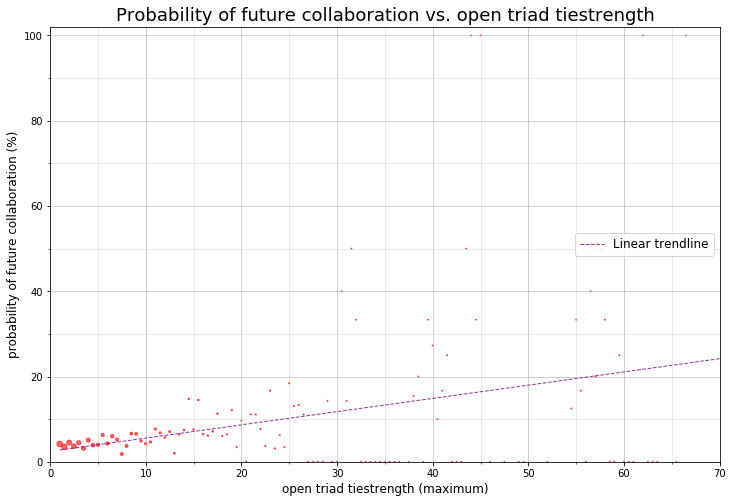

In [50]:
# BEGIN SOLUTION
def calculate_tie_strengths(graph, mode='MAX'):
    
    """
    Cacluates TieStrength of open node pairs on a triad.
    """
    
    results = {} #dictionary of format {[tuple node pair]:  float tiestrength}
    
    for node_pivot in graph.nodes(): #loop through all nodes
        # Generate a list of neighbor tuples, but only adds tuples with node_1 > node_2 to avoid duplicates (as the tuple (2,1) is seen as a different entry than (1,2) although they have the same contents ) 
        neighbor_tuples = [ (node_1, node_2) for node_1 in graph[node_pivot] for node_2 in graph[node_pivot] if node_1 > node_2 ]
        for node_1, node_2 in neighbor_tuples: 
            if node_2 not in graph[node_1]: #as long as node_11 and node_2 are not connected they are the open ends of a triad
                
                pair = tuple([node_1, node_2])
                tie_strength = (float(graph[node_pivot][node_1][0]['weight']) + float(graph[node_pivot][node_2][0]['weight']))/2 #formula tiestrength = (collaborations between A and B + collaborations between B and C) / 2
                
                if pair not in results:
                    results[pair] = tie_strength
                else:
                    if mode == 'ADD': #in adding mode if two nodes are in multiple open triads together the tiestrengths are summed
                        results[pair] += tie_strength
                    else: #'MAX' in maximum mode only the highest tiestrength will be considered
                        if tie_strength>results[pair]:
                            results[pair] = tie_strength
                        
    return results



def plot_tie_strength_prediction(pair_strength_dictionary,new_graph,old_graph,mode = 'MAX'):
    """
    Transforms mutual tie strength data into a plot that gives the probability of future collaboration
    """
    
    if mode != 'ADD' and mode != 'MAX':
        mode = 'MAX'
        
     
    
    raw_data = {} #dictionary of format {[float tie strength]: float the ratio of pairs that ended up collaborating, occurences of that tiestrength}
    for pair,tie_strength in pair_strength_dictionary.items():
        #for each weight get a probability of connection
        
        
        neighbors_in_new_graph = neighbors(new_graph,pair)


    
        if tie_strength not in raw_data:
            if neighbors_in_new_graph:
                raw_data[tie_strength] = [1.000,1] # This tie strength has 100% collaboration rate, and occurred once
            else:
                raw_data[tie_strength] = [0.000,1] # This tie strength has 0% collaboration rate, and occurred once
        else:
            raw_data[tie_strength][1] += 1 # Increase amount of times this tie strength occurred
            
            # Update the ratio of how many pairs collaborated by taking the previous
            raw_data[tie_strength][0] = raw_data[tie_strength][0] + ((int(neighbors_in_new_graph)-raw_data[tie_strength][0])/raw_data[tie_strength][1])
    
    sorted_data = []
    for key in raw_data:
        sorted_data.append([key, raw_data[key][0]*100,raw_data[key][1]])
    sorted_data.sort()
    x,y,scale = zip(*sorted_data) # Generate data for plot: x and y values, and their "scale" (how many measurements this point is based upon) 

    max_scale = max(scale)
    scale_list = []
    for val in scale: # Changes the scale values to be between 1 and 30 so that it looks good when plotting 
        scale_list.append(np.interp(val,[1,max_scale],[1,30]))
    
    #everything graph make-up related is done below here
    fig,ax = plt.subplots()
    
    plt.title('Probability of future collaboration vs. open triad tiestrength', fontsize = 18) 
    plt.ylabel('probability of future collaboration (%)', fontsize = 12)
    if mode == 'ADD':
        plt.xlabel('open triad tiestrengths (summed)', fontsize = 12)
    if mode == 'MAX':
        plt.xlabel('open triad tiestrength (maximum)', fontsize = 12)
    
    x_max = max(x)
    major_ticks_x = np.arange(0,x_max,10)
    minor_ticks_x = np.arange(0,x_max,5)
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor = True)
    plt.xlim(0)
    
    y_max = max(y)
    major_ticks_y = np.arange(0,y_max+10,20)
    minor_ticks_y = np.arange(0,y_max,10)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor = True)
    plt.ylim(0,102)
    
    ax.grid(which='major', alpha = 0.6)
    ax.grid(which='minor', alpha = 0.3)
    
    scatter = plt.scatter(x,y, alpha = 0.6, s = scale_list, c= 'r')
    
    polynomial_coefficients = np.polyfit(x,y, 1) # Returns coefficients of a polynomial of degree 1 (just a linear relation) with least square fit to data
    polynomial = np.poly1d(polynomial_coefficients) # Generate a polynomial from these coefficients
    
    # This polynomial is just the trend line
    # polynomial(i) for any number i evaluates the polynomial at x = i, and returns the value of y at that point
    
    # Plot trend line
    trendline = plt.plot(x,polynomial(x), '--', color = "purple", alpha = 0.8, lw = 1, label = 'Linear trendline')
       
    ax.legend(loc = 'center right', fontsize = 12)
    
    plt.show()
    
    return polynomial
    
    
def neighbors(graph, pair):
    return pair[0] in graph[pair[1]]
    
def max(array):
    return sorted(array)[-1] #get max value by sorting array and taking the first entry

# END SOLUTION    
tie_strengths = calculate_tie_strengths(G1995,'MAX')    
tie_strength_trendline = plot_tie_strength_prediction(tie_strengths,G2015,G1995,'MAX')

## explanation

It looks like especially in the lower regions of collaboration based tie strength there is a clear trend. An increase in tiestrength between two researhers that have not yet worked together correlates to a higher chance that the researchers will collaborate in the future.

# Predictive Power of the Number of Open Triades                                     <a id="chapter6"></a>

Evaluate whether the number of open triades influences the probability that a new collaboration is formed between 1995 and 2015. For example, node B and C do not have an edge, but could be connected by A (one open triad), A and D (two open triades) or even A, D and E (three open triades) and so forth.

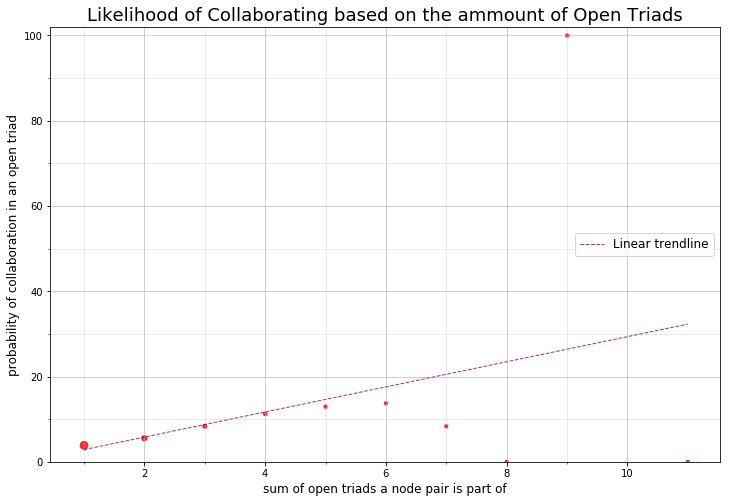

In [49]:
# BEGIN SOLUTION

def open_triangle_count(graph):
    """
    Cacluates the amount of open triads a pair of nodes on the open end are part of.
    Returns a dictionary with mapping { tuple of format (author1,author2) : amount of shared open triangles }
    """
    
    results = {}
    for node_pivot in graph.nodes():
        neighbor_tuples = [ (node_1, node_2) for node_1 in graph[node_pivot] for node_2 in graph[node_pivot] if node_1 > node_2 ]
        for node_1, node_2 in neighbor_tuples:  
            if node_2 not in graph[node_1]: # if node 2 is not a neighbor of node 1
                r = tuple([node_1, node_2])                
                if r not in results:
                    results[r] = 1
                else:
                    results[r] += 1
                        
    return results


def plot_open_triad_prediction(pair_count_dictionary,new_graph, old_graph):
    """
    Produces a plot that relates likelihood to collaborate between researchers to the amount of open triads that they share
    """
    
    
    raw_data = {} #dictionary of format {amount of open triads : [nr of times authors collaborated, nr of times they did not]}
    for pair,triangle_count in pair_count_dictionary.items():
        #for each count get a probability of connection
    
        
    
        if triangle_count not in raw_data: # triangle count has not been processed before
                raw_data[triangle_count] = [0.0,0.0] # this triangle count has 0 times 
                
        if neighbors(new_graph,pair): # If the nodes share an edge in new graph
            raw_data[triangle_count][0] += 1 # The authors collaborated: increase the rate of collaborating by 1
        else:
            raw_data[triangle_count][1] += 1 # Authors did not collaborate. Increase rate of not collaborating by 1
            
    sorted_data = []
    for triangle_count,collab_rates in raw_data.items():
        collaboration_rate = collab_rates[0]
        no_collaboration_rate = collab_rates[1]
        total = float(collaboration_rate + no_collaboration_rate)
        avg = float(collaboration_rate) / total
        sorted_data.append([triangle_count, avg*100, total])
    sorted_data.sort()

    
    # From here onwards, the same principles are used as in the previous exercise. 
    # Array is zipped to produce x,y,scale vals. Scale = amount of measurements for this point
    x,y,scale = zip(*sorted_data)
        
    max_scale = max(scale) #get max value by sorting array and taking the first entry
    scale_list = []
    for val in scale:
        scale_list.append(np.interp(val,[1,max_scale],[10,60]))
    
    fig,ax = plt.subplots()
    
    plt.title('Likelihood of Collaborating based on the ammount of Open Triads', fontsize = 18)
    plt.ylabel('probability of collaboration in an open triad', fontsize = 12)
    plt.xlabel('sum of open triads a node pair is part of', fontsize = 12)
    
    x_max = max(x)
    major_ticks_x = np.arange(0,x_max,2)
    minor_ticks_x = np.arange(0,x_max,1)
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor = True)

    y_max = max(y)
    major_ticks_y = np.arange(0,y_max+10,20)
    minor_ticks_y = np.arange(0,y_max,10)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor = True)
    plt.ylim(0,102)
    
#     y_max = max(y)
#     major_ticks_y = np.arange(0,y_max,0.2)
#     minor_ticks_y = np.arange(0,y_max,0.1)
#     ax.set_yticks(major_ticks_y)
#     ax.set_yticks(minor_ticks_y, minor = True)
    
    ax.grid(which='major', alpha = 0.6)
    ax.grid(which='minor', alpha = 0.3)
    
    scatter = plt.scatter(x,y, alpha = 0.8, s = scale_list, c= 'r')
    
    polynomial_coefficients = np.polyfit(x,y, 1)
    polynomial = np.poly1d(polynomial_coefficients)
    trendline = plt.plot(x,polynomial(x), '--', color = "purple", alpha = 0.8, linewidth = 1, label = 'Linear trendline')
        
    ax.legend(loc = 'center right', fontsize = 12)

    plt.show()
    return polynomial    
    
# END SOLUTION
triangle_counts = open_triangle_count(G1995)
open_triad_trendline = plot_open_triad_prediction(triangle_counts,G2015,G1995)

## explanation

We can see here that the amount of open triangles shared by two nodes is a somewhat reliable way to see if they will connect in the future.
The trend line does not follow the data as nicely as in the previous exercise, but there is a clear, non-random correlation between the amount of shared open triangles, and the likelihood of two scientists to collaborate in the future.
This is in line with our expectations.
The drop off at the end of the plot is interesting, and can have various theoretical explanations.
Possibly, if two scientists already have a very large number of shared friends, but they still have not collaborated, there may be a conscious reason why these scientists choose not to do so. 
Or, this might be due to external circumstances.
Examples of such situations are:one of the scientists has stopped working for the university, or the scientists dislike each other.

# Ranking Friends of Friends                                     <a id="chapter7"></a>

In this exercise you should apply your knowlege gained from the two previous exercises to answer a common problem in todays social media platforms: given a person, an employee in our case, generate a ranked list of his friends of friends that are likely to become his friends. At the end of the following cell, we provide a code snippet that calculates the precision of your algorithm in predicting future ties in the top-10. 

943855 0.55
587677 0.4
905252 0.15
839906 0.35
554748 0.25
220387 0.15
456096 0.15
136755 0.25
652488 0.3
617192 0.25
154879 0.35
860536 0.25
127930 0.35
266261 0.4
925761 0.4
334823 0.35
879631 0.25
922044 0.3
485657 0.1
347203 0.3


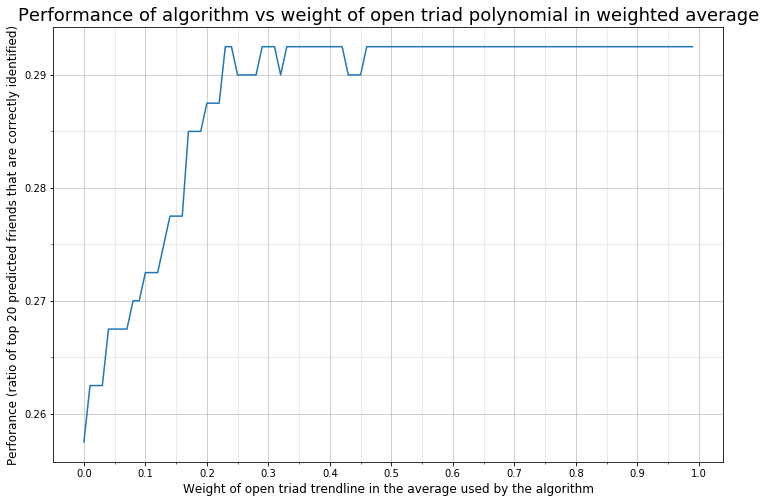

In [35]:
# employees to test
nodes = ['943855', '587677', '905252', '839906', '554748', '220387', '456096', '136755', '652488', '617192', '154879', '860536', '127930', '266261', '925761', '334823', '879631', '922044', '485657', '347203']
# dictionary mapping an employee to a list of employees with whom he/she collaborated in 2015 and which belonged
# to his friends of friends in 1995. 
result = {'879631': ['587677', '265264', '925761', '860536', '725186', '721127', '142327', '23872', '943855'], '127930': ['26850', '935705', '136755', '659445', '805057', '293364', '681672', '565759', '868762', '596394'], '154879': ['691913', '817338', '659445', '169325', '542646', '644335', '293364', '165240', '485657', '905252', '408618'], '587677': ['879631', '725186', '785747', '70007', '561122', '136755', '721127', '142327', '72828', '334823', '839906', '433369', '943855'], '266261': ['265264', '208388', '70007', '495819', '725186', '839906', '136755', '721127', '142327', '408600'], '860536': ['811970', '879631', '456096', '839906', '396817', '136755', '653075', '72828', '596215', '346572', '922044'], '839906': ['587677', '308351', '860536', '378229', '240448', '379649', '334823', '201753', '565759', '943855', '174262', '922044', '266261'], '347203': ['265464', '578175', '136755', '596215', '220387', '906277', '897180', '652488'], '617192': ['793831', '254964', '522310', '932010', '528813', '922964', '485657', '58492', '694245', '166980', '905252'], '136755': ['811970', '127930', '587677', '266261', '815411', '422460', '860536', '347203', '943855', '691913', '174262', '922044'], '925761': ['879631', '725186', '456096', '70007', '561122', '136803', '596215', '334823', '905252', '943855'], '554748': ['23872', '916957', '659445', '169325', '644335', '293364', '220387', '433369', '943855', '174262', '922044', '652488'], '334823': ['587677', '725186', '785747', '839906', '721127', '142327', '72828', '925761', '943855', '867536'], '220387': ['450166', '571150', '565465', '901612', '554748', '18282', '883925', '347203', '9418', '943855', '265464', '652488'], '485657': ['811970', '154879', '617192', '702341', '41963', '661899', '293364', '668817', '218489'], '905252': ['23872', '742360', '561250', '523695', '222137', '617192', '564846', '925761', '661899', '571150', '154879', '691913', '392536'], '943855': ['265264', '60541', '220387', '14499', '783415', '679997', '811970', '785747', '961828', '587677', '925761', '905502', '561122', '136755', '41963', '554748', '879631', '642974', '725186', '676753', '839906', '213482', '396817', '721127', '576951', '334823', '978812'], '456096': ['206983', '925761', '706765', '860536', '565708', '296067', '902949', '549825', '201753', '961828', '240448', '922044'], '922044': ['456096', '308351', '860536', '839906', '136755', '554748', '433369', '999230', '240448'], '652488': ['602959', '60541', '846007', '143158', '347203', '422460', '14499', '554748', '220387', '265464', '9418']}

def fof(graph,node):
    """
    returns the friends of friends of Node n in Graph G
    """
    res = set()
    for neighbor in graph[node]:
        res = res | set(graph[neighbor])
    res = res - set(graph[node])
    res.remove(node) # We added this line here to remove the node itself from this set of its FOFs, as it caused problems in our own code.
    return res

def score(node, friend, balance):
    """
    calculates a score by which potential friends should be sorted
    """
    s = 0
    # BEGIN SOLUTION
    if node > friend:
        pair = (node,friend)
    else:
        pair = (friend,node)
    
    tie_strength = tie_strengths[pair]
    triangle_count = triangle_counts[pair]
    score = (open_triad_trendline(triangle_count)*balance + tie_strength_trendline(tie_strength)*(1-balance) )
    
    # END SOLUTION
    return score

# Check 
topn = 20

#BEGIN SOLUTION
averages=[]
balances=np.arange(0,1,0.01)
# balances = [0.37]
for balance in balances:
    scores=[]
    
    #END SOLUTION
    for node in nodes:
        # get all friends of friends and their score
        fofG1995 = fof(G1995, node)
        l = [(f,score(node,f,balance)) for f in fofG1995 ]
        # sort descending by score
        l.sort(key=lambda x: -x[1])
        # count number of correct results
        found = 0
        for x,z in l[:topn]:
            if x in result[node]:
                found += 1    
        performance = found / float (topn)
        if balance == 0.37: #The best balance value of 0.37 was identified beforehand. We only print the performance here, to avoid printing large amounts of text
            print node, performance 
    
        scores.append(performance)
    # BEGIN SOLUTION
    avg = sum(scores)/len(scores)
    averages.append(avg)

    
# Code we added for plotting below

fig,ax = plt.subplots()
    
plt.title('Performance of algorithm vs weight of open triad polynomial in weighted average', fontsize = 18)
plt.ylabel('Perforance (ratio of top 20 predicted friends that are correctly identified)', fontsize = 12)
plt.xlabel('Weight of open triad trendline in the average used by the algorithm', fontsize = 12)

x_max = max(balances)
major_ticks_x = np.arange(0,x_max+0.05,0.1)
minor_ticks_x = np.arange(0,x_max+0.05,0.05)

ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor = True)

y_max = max(averages)
major_ticks_y = np.arange(0,y_max+0.01,0.01)
minor_ticks_y = np.arange(0,y_max+0.01,0.005)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor = True)


ax.grid(which='major', alpha = 0.6)
ax.grid(which='minor', alpha = 0.3)

plt.plot(balances,averages)
    

plt.show()
# END SOLUTION

**Explanation:**

The algorithm used is quite simple. We generated polynomials (trend lines) for the plots in the previous exercises. These are called open_triad_trendline and tie_strength_trendline.
We use the previously calculated amount of open triangles for each pair of nodes, as input for the open triangles polynomial. Let's call the output of this A.
We also use the previously calculated tie strengths between potential new collaborators, as input for the tie strength trendline. Let's call this output B.  
Then, we take the weighted average of the two. We started out by setting both weights to be 0.5 (so, the mean of the two outputs).
We wondered if there would be a better distribution. Thus, we changed the code that was provided to loop through a list of [0,0.01,0.02...0.99] as the weights.
We then plot the performance of the algorithm versus these weights. It turns out the best weight is 0.37.
Thus, our algorithm is:

$score = triangle\_trendline(number\ of\ shared\ op\ triangles) \cdot 0.37 + tie\_strength\_trendline(tie\ strength) \cdot (1-0.37)$
  
The average performance of this is that, out of 20 most likely predicted new "friends", 29.5% are indeed new "friends". This numer is by no means perfect, but this is quite good when compared to other potential solutions. 

To compare this to the performance of other "algorithms" that we tested:

Our algorithm: 29.5%

$score = 0$: 13%

$score = random.random()$: 17%

$score = triangle\_trendline(number\ of\ shared\ op\ triangles)$: 29%

$score = tie\_strength\_trendline(tie\ strength)$: 24%